<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/VAEGAN_Densenet201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


To take a quick anonymous survey, run:
  $ gcloud alpha survey



In [0]:
model_save_path = "vaegan_dn201_1.pt"
disc_opt_save_path = "vaegan_dn201_opt_disc_1.pt"
enc_opt_save_path = "vaegan_dn201_opt_enc_1.pt"
dec_opt_save_path = "vaegan_dn201_opt_dec_1.pt"

In [3]:
!gsutil cp gs://{bucket_name}/{model_save_path} ./{model_save_path} 
!gsutil cp gs://{bucket_name}/{disc_opt_save_path} ./{disc_opt_save_path} 
!gsutil cp gs://{bucket_name}/{dec_opt_save_path} ./{dec_opt_save_path} 
!gsutil cp gs://{bucket_name}/{enc_opt_save_path} ./{enc_opt_save_path} 

Copying gs://gan-faces/vaegan_dn201_1.pt...
| [1 files][220.2 MiB/220.2 MiB]                                                
Operation completed over 1 objects/220.2 MiB.                                    
Copying gs://gan-faces/vaegan_dn201_opt_disc_1.pt...
/ [1 files][ 69.4 MiB/ 69.4 MiB]                                                
Operation completed over 1 objects/69.4 MiB.                                     
Copying gs://gan-faces/vaegan_dn201_opt_dec_1.pt...
| [1 files][ 72.0 MiB/ 72.0 MiB]                                                
Operation completed over 1 objects/72.0 MiB.                                     
Copying gs://gan-faces/vaegan_dn201_opt_enc_1.pt...
/ [1 files][ 76.6 MiB/ 76.6 MiB]                                                
Operation completed over 1 objects/76.6 MiB.                                     


In [4]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/images')
  zip_ref.close()

# if not os.path.exists("wiki_images_good.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./ 
#   zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
#   zip_ref.extractall('data/wiki_images')
#   zip_ref.close()  

# if not os.path.exists("celeb_a_good.zip"):
# #   !kaggle datasets download -d jessicali9530/celeba-dataset
#   !gsutil cp gs://{bucket_name}/celeb_a_good.zip ./celeb_a_good.zip
#   zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
#   zip_ref.extractall('data/images/celeb_a')
#   zip_ref.close()

# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images/training')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://gan-faces/celeba-dataset.zip...
- [1 files][  1.2 GiB/  1.2 GiB]   62.7 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      


In [5]:
if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  

Copying gs://gan-faces/wiki_images_good.zip...
- [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     


In [0]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

In [0]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    # @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseBlock(nn.Module):
    _version = 2
    __constants__ = ['layers']

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleDict()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.layers['denselayer%d' % (i + 1)] = layer

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.layers.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

    @torch.jit.ignore
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = local_metadata.get('version', None)
        if (version is None or version < 2):
            # now we have a new nesting level for torchscript support
            for new_key in self.state_dict().keys():
                # remove prefix "layers."
                old_key = new_key[len("layers."):]
                old_key = prefix + old_key
                new_key = prefix + new_key
                if old_key in state_dict:
                    value = state_dict[old_key]
                    del state_dict[old_key]
                    state_dict[new_key] = value
        super(_DenseBlock, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

class DenseNet(torchvision.models.densenet.DenseNet):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    __constants__ = ['features']
    
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.LeakyReLU(0.2, inplace=True)),
            ('pool0', nn.AvgPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        features = self.features(x)
        feature_map = F.relu(features, inplace=False)
        out = F.adaptive_avg_pool2d(feature_map, (1, 1))
        out = torch.flatten(out, 1)
        output = self.classifier(out, feature_map=features)
        return output
    
def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model        
        
def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)   

def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=0, bias=False):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride,
                                       bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=False)

    def forward(self, ten):
        c1 = self.conv(ten)
        bn = self.bn(c1)
        relu = self.relu(bn)
        return relu
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, ngf=64, ngpu=1):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 12, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 12),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 12, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*2) x 20 x 20
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 40 x 40
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 80 x 80
            nn.ConvTranspose2d( ngf * 1, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 160 x 160
        )

    def forward(self, input):
        return self.main(input.view(input.shape[0], -1, 1, 1))
    
class DiscriminatorOutput(nn.Module):
    def __init__(self, num_ftrs):
        super(DiscriminatorOutput, self).__init__()
        # Two FC Layers to output discriminator and aux output
        self.discriminator = nn.Linear(num_ftrs, 1)
        self.aux = nn.Linear(num_ftrs, 40)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, features, feature_map=None):
        output = self.discriminator(features)
        aux_output = self.aux(features)
        
        return self.sigmoid(output), feature_map, self.sigmoid(aux_output)

class EncoderOutput(nn.Module):
    def __init__(self, num_ftrs, latent_dim=256):
        super(EncoderOutput, self).__init__()
        # Two FC Layers to output code and logvar
        self.code = nn.Linear(num_ftrs, latent_dim)
        self.logvar = nn.Linear(num_ftrs, latent_dim)
        
    def forward(self, features, feature_map=None):
        code = self.code(features)
        logvar = self.logvar(features)
        return code, logvar

class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=5):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        
        self.encoder = densenet201(pretrained=True)
        num_ftrs = self.encoder.classifier.in_features
        self.encoder.classifier = EncoderOutput(num_ftrs=num_ftrs, latent_dim=z_size)   

        self.decoder = Decoder(latent_dim=self.z_size, ngf=64)
        
        self.discriminator = densenet201(pretrained=True)
        num_ftrs = self.discriminator.classifier.in_features
        self.discriminator.classifier = DiscriminatorOutput(num_ftrs=num_ftrs)
        
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)  

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)
#             print("Encoded")
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
#             print("Decoded")
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            #discriminator
            disc_out, fm, aux_out = self.discriminator(torch.cat((ten, ten_original,ten_from_normal), 0))
                  
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="none")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
#         weights = labels + 1
        weights = 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted,layer_sampled, labels_original,
             labels_predicted,labels_sampled, mus, variances, aux_out, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        
        aux_loss = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon, aux_loss         

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [9]:
image_labels = pd.read_csv("data/list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
            targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
#             targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 12
data_path = "data/images"
image_size = (160,160)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [10]:
z_size = 512
recon_level = 4
decay_lr = 0.75
lambda_mse = 1e-6
lr = 3e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.35
equilibrium = 0.68
#mse_lambda = 1.0
# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
#optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
#lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:00<00:00, 84.9MB/s]


In [11]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 20060032
Decoder Params: 18880896
Discriminator Params: 18171689


In [0]:
model_save_path = "vaegan_dn201_1.pt"
disc_opt_save_path = "vaegan_dn201_opt_disc_1.pt"
enc_opt_save_path = "vaegan_dn201_opt_enc_1.pt"
dec_opt_save_path = "vaegan_dn201_opt_dec_1.pt"

In [0]:
net.load_state_dict(torch.load(model_save_path))
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [0]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader):
    lambda_mse = 1e-6
    lambda_aux = 0.25
    decay_mse = 1
    decay_equilibrium = 1
    margin = 0.35
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()
            
            #print("LR:{}".format(lr_encoder.get_lr()))

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1)+torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse/2 * mse_value_1)+ torch.sum(lambda_mse/2 * mse_value_2) + (1.0 - lambda_mse) * loss_decoder

                # register mean values of the losses for logging
                loss_nle_mean(torch.mean(nle_value).data.cpu().item())
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1/2)+torch.mean(lambda_mse * mse_value_2/2) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).data.cpu().item())

                aux_f1(masked_f1_score(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)+ torch.mean(mse_value_2)).data.cpu().item())
                loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).data.cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                    train_dis = False
                if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                    train_dec = False
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                # encoder
                loss_encoder.backward(retain_graph=True)
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                #discriminator
                if train_dis:
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()

                if j % 100 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader),
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_predicted.mean().item(), out_labels_predicted.mean().item()))
                if j % 500 == 0 and j > 0:
                    with torch.no_grad():
                      out = (out * 0.5) + 0.5
                      fig, ax = plt.subplots(1, 2, figsize=(7,7))
                      ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()

            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

    !gsutil cp ./{model_save_path} gs://{bucket_name}/{model_save_path}
    !gsutil cp ./{disc_opt_save_path} gs://{bucket_name}/{disc_opt_save_path}
    !gsutil cp ./{dec_opt_save_path} gs://{bucket_name}/{dec_opt_save_path}
    !gsutil cp ./{enc_opt_save_path} gs://{bucket_name}/{enc_opt_save_path}        

[0/1][0/16884]	Loss_D: 1.0823	Loss_Dec: 3.0794	Aux F1: 0.8375	Loss_Enc: 2651.5869	D(x): 0.3031	D(G(z)): 0.3031
[0/1][100/16884]	Loss_D: 1.1327	Loss_Dec: 2.8418	Aux F1: 0.8281	Loss_Enc: 2676.4234	D(x): 0.2802	D(G(z)): 0.2802
[0/1][200/16884]	Loss_D: 1.1160	Loss_Dec: 2.9056	Aux F1: 0.8283	Loss_Enc: 2779.8057	D(x): 0.2658	D(G(z)): 0.2658
[0/1][300/16884]	Loss_D: 1.0920	Loss_Dec: 2.9556	Aux F1: 0.8289	Loss_Enc: 2801.6714	D(x): 0.2543	D(G(z)): 0.2543
[0/1][400/16884]	Loss_D: 1.1012	Loss_Dec: 2.9431	Aux F1: 0.8291	Loss_Enc: 2776.2948	D(x): 0.2426	D(G(z)): 0.2426
[0/1][500/16884]	Loss_D: 1.1047	Loss_Dec: 2.9144	Aux F1: 0.8286	Loss_Enc: 2739.7107	D(x): 0.2822	D(G(z)): 0.2822


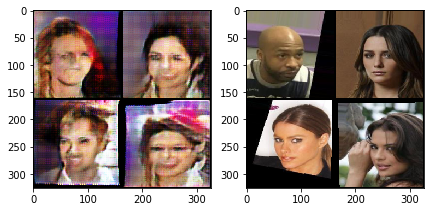

[0/1][600/16884]	Loss_D: 1.1031	Loss_Dec: 2.9091	Aux F1: 0.8285	Loss_Enc: 2723.8360	D(x): 0.2974	D(G(z)): 0.2974
[0/1][700/16884]	Loss_D: 1.1040	Loss_Dec: 2.9110	Aux F1: 0.8284	Loss_Enc: 2721.7299	D(x): 0.2684	D(G(z)): 0.2684
[0/1][800/16884]	Loss_D: 1.0991	Loss_Dec: 2.9321	Aux F1: 0.8276	Loss_Enc: 2734.1723	D(x): 0.2908	D(G(z)): 0.2908
[0/1][900/16884]	Loss_D: 1.0970	Loss_Dec: 2.9550	Aux F1: 0.8273	Loss_Enc: 2752.6724	D(x): 0.2677	D(G(z)): 0.2677
[0/1][1000/16884]	Loss_D: 1.0932	Loss_Dec: 2.9695	Aux F1: 0.8276	Loss_Enc: 2768.7534	D(x): 0.2862	D(G(z)): 0.2862


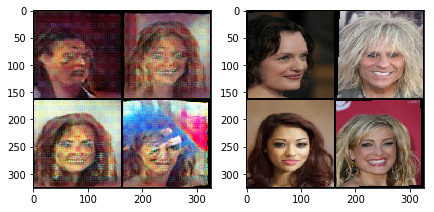

[0/1][1100/16884]	Loss_D: 1.0905	Loss_Dec: 2.9932	Aux F1: 0.8277	Loss_Enc: 2778.9767	D(x): 0.3989	D(G(z)): 0.3989
[0/1][1200/16884]	Loss_D: 1.0930	Loss_Dec: 3.0061	Aux F1: 0.8275	Loss_Enc: 2787.8062	D(x): 0.2836	D(G(z)): 0.2836
[0/1][1300/16884]	Loss_D: 1.0917	Loss_Dec: 3.0302	Aux F1: 0.8276	Loss_Enc: 2798.4261	D(x): 0.2451	D(G(z)): 0.2451
[0/1][1400/16884]	Loss_D: 1.0891	Loss_Dec: 3.0416	Aux F1: 0.8276	Loss_Enc: 2810.0801	D(x): 0.4183	D(G(z)): 0.4183
[0/1][1500/16884]	Loss_D: 1.0913	Loss_Dec: 3.0313	Aux F1: 0.8277	Loss_Enc: 2804.7467	D(x): 0.1946	D(G(z)): 0.1946


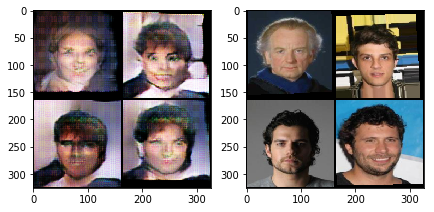

[0/1][1600/16884]	Loss_D: 1.0901	Loss_Dec: 3.0290	Aux F1: 0.8277	Loss_Enc: 2803.3521	D(x): 0.2527	D(G(z)): 0.2527
[0/1][1700/16884]	Loss_D: 1.0902	Loss_Dec: 3.0269	Aux F1: 0.8279	Loss_Enc: 2798.0790	D(x): 0.2391	D(G(z)): 0.2391
[0/1][1800/16884]	Loss_D: 1.0910	Loss_Dec: 3.0227	Aux F1: 0.8280	Loss_Enc: 2785.6740	D(x): 0.3032	D(G(z)): 0.3032
[0/1][1900/16884]	Loss_D: 1.0884	Loss_Dec: 3.0234	Aux F1: 0.8280	Loss_Enc: 2790.3776	D(x): 0.2030	D(G(z)): 0.2030
[0/1][2000/16884]	Loss_D: 1.0855	Loss_Dec: 3.0316	Aux F1: 0.8278	Loss_Enc: 2797.9554	D(x): 0.3403	D(G(z)): 0.3403


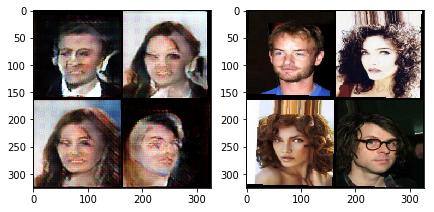

[0/1][2100/16884]	Loss_D: 1.0824	Loss_Dec: 3.0427	Aux F1: 0.8276	Loss_Enc: 2802.6949	D(x): 0.2002	D(G(z)): 0.2002
[0/1][2200/16884]	Loss_D: 1.0803	Loss_Dec: 3.0466	Aux F1: 0.8275	Loss_Enc: 2805.3965	D(x): 0.2833	D(G(z)): 0.2833
[0/1][2300/16884]	Loss_D: 1.0824	Loss_Dec: 3.0361	Aux F1: 0.8277	Loss_Enc: 2799.4247	D(x): 0.2843	D(G(z)): 0.2843
[0/1][2400/16884]	Loss_D: 1.0832	Loss_Dec: 3.0297	Aux F1: 0.8278	Loss_Enc: 2792.4413	D(x): 0.3520	D(G(z)): 0.3520
[0/1][2500/16884]	Loss_D: 1.0833	Loss_Dec: 3.0258	Aux F1: 0.8278	Loss_Enc: 2787.5353	D(x): 0.2144	D(G(z)): 0.2144


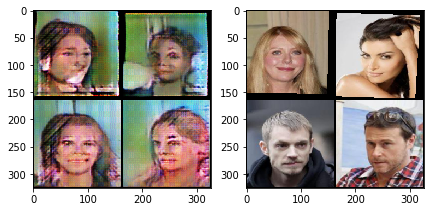

[0/1][2600/16884]	Loss_D: 1.0845	Loss_Dec: 3.0149	Aux F1: 0.8277	Loss_Enc: 2781.0502	D(x): 0.3179	D(G(z)): 0.3179
[0/1][2700/16884]	Loss_D: 1.0858	Loss_Dec: 3.0054	Aux F1: 0.8278	Loss_Enc: 2770.3227	D(x): 0.3377	D(G(z)): 0.3377
[0/1][2800/16884]	Loss_D: 1.0852	Loss_Dec: 3.0035	Aux F1: 0.8279	Loss_Enc: 2762.7109	D(x): 0.3348	D(G(z)): 0.3348
[0/1][2900/16884]	Loss_D: 1.0852	Loss_Dec: 3.0030	Aux F1: 0.8280	Loss_Enc: 2758.1759	D(x): 0.2889	D(G(z)): 0.2889
[0/1][3000/16884]	Loss_D: 1.0855	Loss_Dec: 3.0055	Aux F1: 0.8280	Loss_Enc: 2756.1582	D(x): 0.2913	D(G(z)): 0.2913


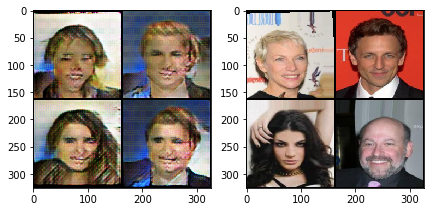

[0/1][3100/16884]	Loss_D: 1.0847	Loss_Dec: 3.0097	Aux F1: 0.8281	Loss_Enc: 2755.5558	D(x): 0.1912	D(G(z)): 0.1912
[0/1][3200/16884]	Loss_D: 1.0845	Loss_Dec: 3.0121	Aux F1: 0.8280	Loss_Enc: 2759.3107	D(x): 0.4084	D(G(z)): 0.4084
[0/1][3300/16884]	Loss_D: 1.0841	Loss_Dec: 3.0154	Aux F1: 0.8279	Loss_Enc: 2760.8300	D(x): 0.2395	D(G(z)): 0.2395
[0/1][3400/16884]	Loss_D: 1.0842	Loss_Dec: 3.0152	Aux F1: 0.8279	Loss_Enc: 2755.8902	D(x): 0.2464	D(G(z)): 0.2464
[0/1][3500/16884]	Loss_D: 1.0840	Loss_Dec: 3.0153	Aux F1: 0.8279	Loss_Enc: 2752.5581	D(x): 0.3848	D(G(z)): 0.3848


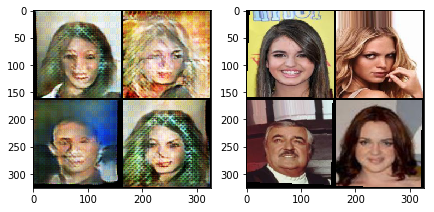

[0/1][3600/16884]	Loss_D: 1.0852	Loss_Dec: 3.0104	Aux F1: 0.8280	Loss_Enc: 2748.0274	D(x): 0.3383	D(G(z)): 0.3383
[0/1][3700/16884]	Loss_D: 1.0864	Loss_Dec: 3.0030	Aux F1: 0.8280	Loss_Enc: 2744.6308	D(x): 0.3673	D(G(z)): 0.3673
[0/1][3800/16884]	Loss_D: 1.0872	Loss_Dec: 3.0011	Aux F1: 0.8279	Loss_Enc: 2744.8069	D(x): 0.4061	D(G(z)): 0.4061
[0/1][3900/16884]	Loss_D: 1.0887	Loss_Dec: 2.9951	Aux F1: 0.8279	Loss_Enc: 2740.7130	D(x): 0.3652	D(G(z)): 0.3652
[0/1][4000/16884]	Loss_D: 1.0900	Loss_Dec: 2.9891	Aux F1: 0.8280	Loss_Enc: 2736.8610	D(x): 0.2725	D(G(z)): 0.2725


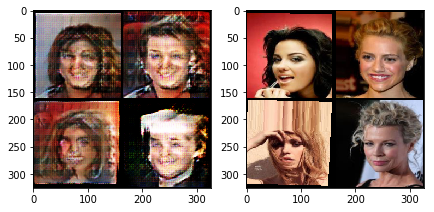

[0/1][4100/16884]	Loss_D: 1.0904	Loss_Dec: 2.9853	Aux F1: 0.8280	Loss_Enc: 2732.9062	D(x): 0.2818	D(G(z)): 0.2818
[0/1][4200/16884]	Loss_D: 1.0909	Loss_Dec: 2.9806	Aux F1: 0.8280	Loss_Enc: 2731.7145	D(x): 0.2847	D(G(z)): 0.2847
[0/1][4300/16884]	Loss_D: 1.0905	Loss_Dec: 2.9820	Aux F1: 0.8279	Loss_Enc: 2730.5563	D(x): 0.3255	D(G(z)): 0.3255
[0/1][4400/16884]	Loss_D: 1.0903	Loss_Dec: 2.9818	Aux F1: 0.8279	Loss_Enc: 2729.3395	D(x): 0.2632	D(G(z)): 0.2632
[0/1][4500/16884]	Loss_D: 1.0898	Loss_Dec: 2.9841	Aux F1: 0.8278	Loss_Enc: 2728.9975	D(x): 0.2911	D(G(z)): 0.2911


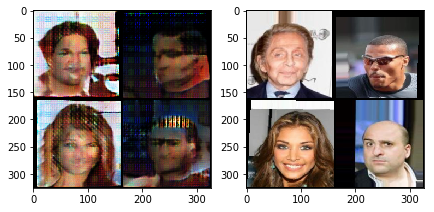

[0/1][4600/16884]	Loss_D: 1.0889	Loss_Dec: 2.9848	Aux F1: 0.8277	Loss_Enc: 2731.6987	D(x): 0.4310	D(G(z)): 0.4310
[0/1][4700/16884]	Loss_D: 1.0894	Loss_Dec: 2.9832	Aux F1: 0.8276	Loss_Enc: 2731.9493	D(x): 0.2918	D(G(z)): 0.2918
[0/1][4800/16884]	Loss_D: 1.0891	Loss_Dec: 2.9814	Aux F1: 0.8275	Loss_Enc: 2731.5006	D(x): 0.3785	D(G(z)): 0.3785
[0/1][4900/16884]	Loss_D: 1.0886	Loss_Dec: 2.9812	Aux F1: 0.8275	Loss_Enc: 2730.4548	D(x): 0.2354	D(G(z)): 0.2354
[0/1][5000/16884]	Loss_D: 1.0881	Loss_Dec: 2.9793	Aux F1: 0.8275	Loss_Enc: 2729.9576	D(x): 0.2715	D(G(z)): 0.2715


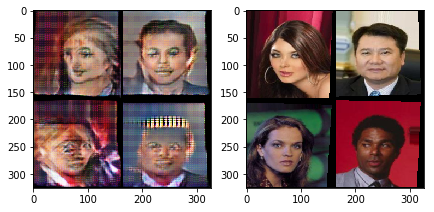

[0/1][5100/16884]	Loss_D: 1.0873	Loss_Dec: 2.9825	Aux F1: 0.8275	Loss_Enc: 2731.3055	D(x): 0.2913	D(G(z)): 0.2913
[0/1][5200/16884]	Loss_D: 1.0873	Loss_Dec: 2.9823	Aux F1: 0.8277	Loss_Enc: 2732.3758	D(x): 0.2633	D(G(z)): 0.2633
[0/1][5300/16884]	Loss_D: 1.0873	Loss_Dec: 2.9797	Aux F1: 0.8277	Loss_Enc: 2730.2605	D(x): 0.2537	D(G(z)): 0.2537
[0/1][5400/16884]	Loss_D: 1.0872	Loss_Dec: 2.9781	Aux F1: 0.8278	Loss_Enc: 2730.2922	D(x): 0.3019	D(G(z)): 0.3019
[0/1][5500/16884]	Loss_D: 1.0876	Loss_Dec: 2.9743	Aux F1: 0.8278	Loss_Enc: 2729.6287	D(x): 0.2357	D(G(z)): 0.2357


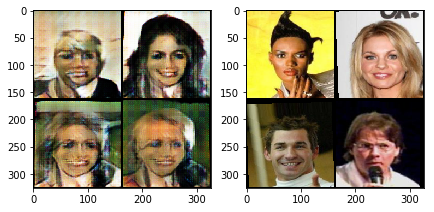

[0/1][5600/16884]	Loss_D: 1.0874	Loss_Dec: 2.9735	Aux F1: 0.8276	Loss_Enc: 2730.1179	D(x): 0.2645	D(G(z)): 0.2645
[0/1][5700/16884]	Loss_D: 1.0878	Loss_Dec: 2.9709	Aux F1: 0.8277	Loss_Enc: 2731.5373	D(x): 0.3020	D(G(z)): 0.3020
[0/1][5800/16884]	Loss_D: 1.0883	Loss_Dec: 2.9680	Aux F1: 0.8276	Loss_Enc: 2732.1811	D(x): 0.2477	D(G(z)): 0.2477
[0/1][5900/16884]	Loss_D: 1.0886	Loss_Dec: 2.9669	Aux F1: 0.8277	Loss_Enc: 2734.2720	D(x): 0.2993	D(G(z)): 0.2993
[0/1][6000/16884]	Loss_D: 1.0887	Loss_Dec: 2.9646	Aux F1: 0.8277	Loss_Enc: 2737.2215	D(x): 0.3713	D(G(z)): 0.3713


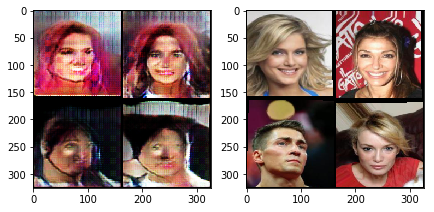

[0/1][6100/16884]	Loss_D: 1.0891	Loss_Dec: 2.9628	Aux F1: 0.8277	Loss_Enc: 2738.6140	D(x): 0.2490	D(G(z)): 0.2490
[0/1][6200/16884]	Loss_D: 1.0896	Loss_Dec: 2.9623	Aux F1: 0.8277	Loss_Enc: 2740.7297	D(x): 0.3240	D(G(z)): 0.3240
[0/1][6300/16884]	Loss_D: 1.0899	Loss_Dec: 2.9618	Aux F1: 0.8277	Loss_Enc: 2742.1417	D(x): 0.3017	D(G(z)): 0.3017
[0/1][6400/16884]	Loss_D: 1.0905	Loss_Dec: 2.9579	Aux F1: 0.8278	Loss_Enc: 2740.3516	D(x): 0.3173	D(G(z)): 0.3173
[0/1][6500/16884]	Loss_D: 1.0911	Loss_Dec: 2.9544	Aux F1: 0.8278	Loss_Enc: 2737.8836	D(x): 0.2361	D(G(z)): 0.2361


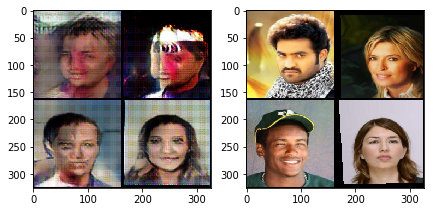

[0/1][6600/16884]	Loss_D: 1.0916	Loss_Dec: 2.9529	Aux F1: 0.8279	Loss_Enc: 2738.0930	D(x): 0.2393	D(G(z)): 0.2393
[0/1][6700/16884]	Loss_D: 1.0915	Loss_Dec: 2.9536	Aux F1: 0.8280	Loss_Enc: 2738.0621	D(x): 0.2408	D(G(z)): 0.2408
[0/1][6800/16884]	Loss_D: 1.0908	Loss_Dec: 2.9567	Aux F1: 0.8279	Loss_Enc: 2738.6550	D(x): 0.2705	D(G(z)): 0.2705
[0/1][6900/16884]	Loss_D: 1.0903	Loss_Dec: 2.9589	Aux F1: 0.8280	Loss_Enc: 2740.7739	D(x): 0.2772	D(G(z)): 0.2772
[0/1][7000/16884]	Loss_D: 1.0898	Loss_Dec: 2.9616	Aux F1: 0.8280	Loss_Enc: 2741.6954	D(x): 0.3221	D(G(z)): 0.3221


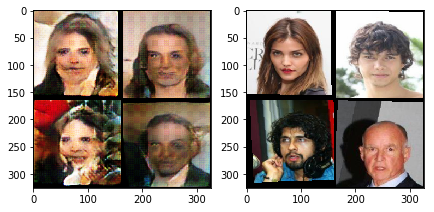

[0/1][7100/16884]	Loss_D: 1.0898	Loss_Dec: 2.9615	Aux F1: 0.8280	Loss_Enc: 2739.9310	D(x): 0.2735	D(G(z)): 0.2735
[0/1][7200/16884]	Loss_D: 1.0897	Loss_Dec: 2.9629	Aux F1: 0.8279	Loss_Enc: 2741.2863	D(x): 0.3019	D(G(z)): 0.3019
[0/1][7300/16884]	Loss_D: 1.0894	Loss_Dec: 2.9641	Aux F1: 0.8279	Loss_Enc: 2741.4639	D(x): 0.2506	D(G(z)): 0.2506
[0/1][7400/16884]	Loss_D: 1.0896	Loss_Dec: 2.9658	Aux F1: 0.8279	Loss_Enc: 2741.2184	D(x): 0.3428	D(G(z)): 0.3428


In [0]:
train(net, n_epochs=1, train_loader=train_loader)

In [0]:
train(net, n_epochs=5, train_loader=train_loader)

In [0]:
for j, (data_batch,target_batch) in enumerate(test_loader):
    data_batch = data_batch.cuda()
    
    out, out_labels, out_layer, mus, variances = net(data_batch)
    
    fig, ax = plt.subplots(1, 2, figsize=(8,8))
    out = (out * 0.5) + 0.5
    ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
    plt.show()   
    break